# Modelių ansamblis laiko eilučių prognozavimui (BTC/USDT)
#
# Šiame notebook sukursime ansamblį iš LSTM, GRU, CNN ir Transformer modelių prognozių.
# Naudosime balsavimo (vidurkio) ir svertinį metodus, įvertinsime ansamblio efektyvumą.

In [17]:
# Reikalingų bibliotekų importavimas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tensorflow.keras.models import load_model
import json

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
# Užkrauname scaler ir testavimo duomenis (naudojame tą patį kaip kituose modeliuose)
models_dir = '../../models'

# Bandome naudoti CNN arba LSTM scaler
scaler_path = os.path.join(models_dir, 'cnn_scaler.pkl')
if not os.path.exists(scaler_path):
    scaler_path = os.path.join(models_dir, 'lstm_scaler.pkl')
if not os.path.exists(scaler_path):
    scaler_path = os.path.join(models_dir, 'gru_scaler.pkl')
if not os.path.exists(scaler_path):
    scaler_path = os.path.join(models_dir, 'transformer_scaler.pkl')

with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# Testavimo duomenų kūrimas (naudojame tą pačią logiką kaip kituose modeliuose)
import requests
from datetime import datetime, timedelta

def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
    BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
    if end_time is None:
        end_time = datetime.now()
    if start_time is None:
        start_time = end_time - timedelta(days=365)
    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    all_klines = []
    current_start = start_ts
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        try:
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            klines = response.json()
            if not klines:
                break
            all_klines.extend(klines)
            current_start = int(klines[-1][0]) + 1
        except Exception as e:
            print(f"Klaida gaunant duomenis: {str(e)}")
    if all_klines:
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df = pd.DataFrame(all_klines, columns=columns)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        return df
    return None

end_time = datetime.now()
start_time = end_time - timedelta(days=365)
df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)
df = df.sort_values('time')
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
feature_columns = columns_to_normalize
target_column = 'close'
sequence_length = 10

df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.transform(df[columns_to_normalize])

def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(df_normalized, target_column, sequence_length)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
target_idx = feature_columns.index(target_column)

In [19]:
# Funkcija prognozių atstatymui į originalią skalę
def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_columns=None):
    dummy = np.zeros((len(predictions), len(feature_columns)))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

In [20]:
# Užkrauname visų modelių svorius ir prognozuojame
model_paths = {
    'LSTM': os.path.join(models_dir, 'lstm_model.h5'),
    'GRU': os.path.join(models_dir, 'gru_model.h5'),
    'CNN': os.path.join(models_dir, 'cnn_model.h5'),
    'Transformer': os.path.join(models_dir, 'transformer_model.h5')
}

predictions = {}
for name, path in model_paths.items():
    if os.path.exists(path):
        try:
            model = load_model(path, compile=False)
            preds = model.predict(X_test)
            preds_original = inverse_transform_predictions(preds, scaler, target_idx, feature_columns)
            predictions[name] = preds_original
            print(f"{name} modelio prognozės užkrautos.")
        except Exception as e:
            print(f"Nepavyko užkrauti {name} modelio: {e}")
    else:
        print(f"{name} modelio failas nerastas.")

y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)
test_dates = df['time'].iloc[-len(y_test):].reset_index(drop=True)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
LSTM modelio prognozės užkrautos.
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
GRU modelio prognozės užkrautos.
Nepavyko užkrauti CNN modelio: Exception encountered when calling Conv1D.call().

Negative dimension size caused by subtracting 3 from 1 for '{{node sequential_1/conv1d_2_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_1/conv1d_2_1/convolution/ExpandDims, sequential_1/conv1d_2_1/convolution/ExpandDims_1)' with input shapes: [32,1,1,128], [1,3,128,128].

Arguments received by Conv1D.call():
  • inputs=tf.Tensor(shape=(32, 1, 128), dtype=float32)
Nepavyko užkrauti Transformer modelio: Unknown layer: 'TimeSeriesTransformer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom

In [21]:
# Ansamblio prognozė: paprastas vidurkis (voting)
ensemble_pred = np.mean([v for v in predictions.values()], axis=0)

# Galite išbandyti ir svertinį ansamblį (pvz., pagal RMSE atvirkštinius svorius)
model_metrics = {}
for name in predictions:
    mse = mean_squared_error(y_test_original, predictions[name])
    rmse = np.sqrt(mse)
    model_metrics[name] = rmse

inv_rmses = np.array([1/model_metrics[name] for name in predictions])
weights = inv_rmses / inv_rmses.sum()
ensemble_pred_weighted = np.zeros_like(ensemble_pred)
for i, name in enumerate(predictions):
    ensemble_pred_weighted += predictions[name] * weights[i]

print("Modelių svoriai (pagal RMSE):")
for i, name in enumerate(predictions):
    print(f"{name}: {weights[i]:.2f}")

Modelių svoriai (pagal RMSE):
LSTM: 0.77
GRU: 0.23


In [22]:
# Ansamblio ir atskirų modelių įvertinimas
def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{label}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}, MAPE={mape:.2f}%")

for name, pred in predictions.items():
    print_metrics(y_test_original, pred, name)
print_metrics(y_test_original, ensemble_pred, "Ansamblis (vidurkis)")
print_metrics(y_test_original, ensemble_pred_weighted, "Ansamblis (svertinis)")

LSTM: RMSE=460.23, MAE=328.83, R2=0.9971, MAPE=0.36%
GRU: RMSE=1529.58, MAE=1021.11, R2=0.9685, MAPE=1.04%
Ansamblis (vidurkis): RMSE=958.53, MAE=658.05, R2=0.9876, MAPE=0.68%
Ansamblis (svertinis): RMSE=670.91, MAE=473.49, R2=0.9939, MAPE=0.50%


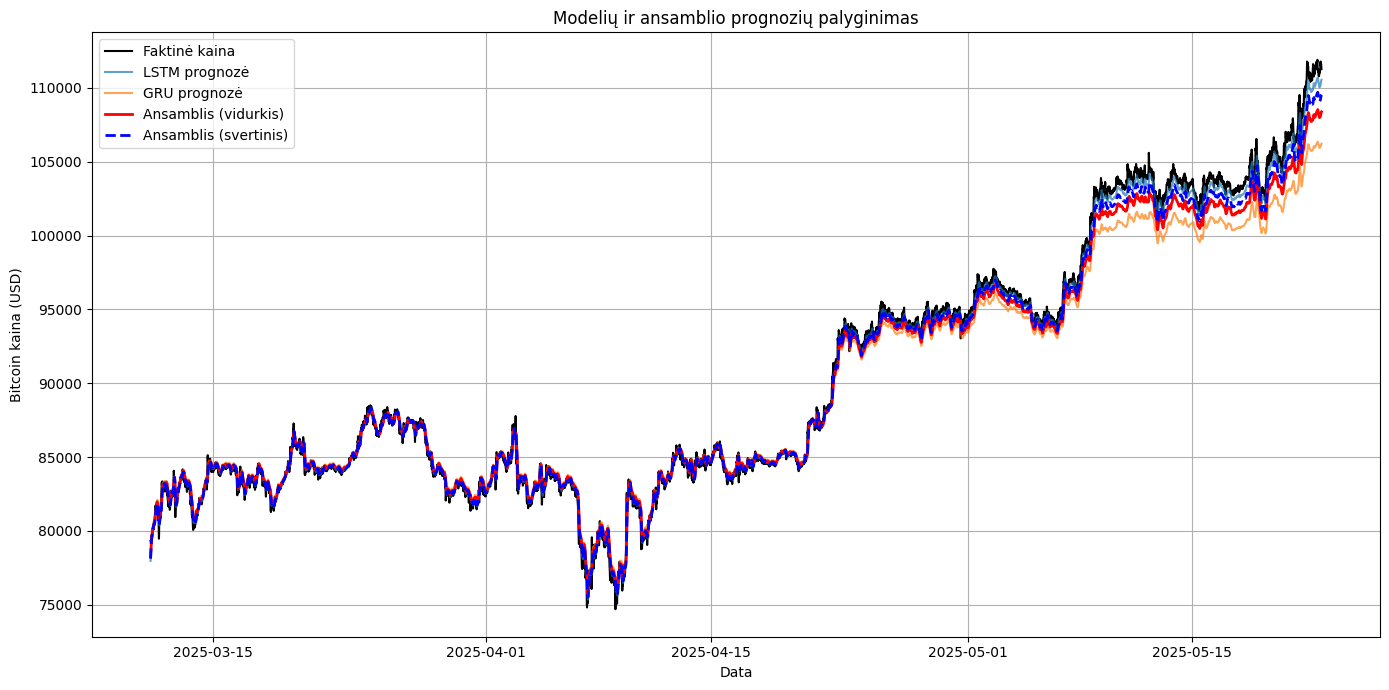

In [23]:
# Vizualizacija
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='black')
for name, pred in predictions.items():
    plt.plot(test_dates, pred, label=f'{name} prognozė', alpha=0.7)
plt.plot(test_dates, ensemble_pred, label='Ansamblis (vidurkis)', color='red', linewidth=2)
plt.plot(test_dates, ensemble_pred_weighted, label='Ansamblis (svertinis)', color='blue', linewidth=2, linestyle='--')
plt.title('Modelių ir ansamblio prognozių palyginimas')
plt.xlabel('Data')
plt.ylabel('Bitcoin kaina (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Ansamblio metrikų išsaugojimas
ensemble_metrics = {
    'ensemble_mean': {
        'rmse': float(np.sqrt(mean_squared_error(y_test_original, ensemble_pred))),
        'mae': float(mean_absolute_error(y_test_original, ensemble_pred)),
        'r2': float(r2_score(y_test_original, ensemble_pred)),
        'mape': float(np.mean(np.abs((y_test_original - ensemble_pred) / y_test_original)) * 100)
    },
    'ensemble_weighted': {
        'rmse': float(np.sqrt(mean_squared_error(y_test_original, ensemble_pred_weighted))),
        'mae': float(mean_absolute_error(y_test_original, ensemble_pred_weighted)),
        'r2': float(r2_score(y_test_original, ensemble_pred_weighted)),
        'mape': float(np.mean(np.abs((y_test_original - ensemble_pred_weighted) / y_test_original)) * 100)
    }
}
with open('../../models/ensemble_model_info.json', 'w') as f:
    json.dump(ensemble_metrics, f, indent=4)
print("Ansamblio metrikos išsaugotos į ../../models/ensemble_model_info.json")

Ansamblio metrikos išsaugotos į ../../models/ensemble_model_info.json
